In [ ]:
# --- SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import warnings

# Setari generale
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

# Dictionare globale
rezultate_finale = {}
metrici_finale = {}
timpi_antrenare = {} 

print("Setup complet. Biblioteci importate.")

Setup complet. Biblioteci importate.


In [9]:
# --- CELULA 2: PIPELINE DATE ---

# 1. Citire
df = pd.read_csv("CLEAN_House1.csv", parse_dates=[0], index_col=0)

# 2. Curatare date
if "Issues" in df.columns:
    df = df[df["Issues"] == 0]
    df = df.drop(columns=["Issues"])

# 3. Resampling la 1 minut
df_1min = df["Aggregate"].resample("1min").mean().to_frame(name="Aggregate").dropna()

# 4. Split Train / Test (80% / 20%)
train_size = int(len(df_1min) * 0.8)
train_data = df_1min.iloc[:train_size]
test_data = df_1min.iloc[train_size:]

print(f"Total Date: {len(df_1min)} | Train: {len(train_data)} | Test: {len(test_data)}")

# 5. Scalare
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

# 6. Functie creare secvente
WINDOW_SIZE = 60 

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train, WINDOW_SIZE)
input_test = np.concatenate((scaled_train[-WINDOW_SIZE:], scaled_test))
X_test, _ = create_sequences(input_test, WINDOW_SIZE)

X_train = X_train.reshape((X_train.shape[0], WINDOW_SIZE, 1))
X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1))

print("Date pregatite.")

Total Date: 800109 | Train: 640087 | Test: 160022
Date pregatite.


In [10]:
# --- CELULA 3: PROPHET ---

# Pregatire date
df_prophet = df_1min.reset_index().rename(columns={"Time": "ds", "Aggregate": "y"})
df_prophet_train = df_prophet.iloc[:train_size]
df_prophet_test = df_prophet.iloc[train_size:]

m_prophet = Prophet()

# --- START TIMER ---
start_time = time.time()
m_prophet.fit(df_prophet_train)
end_time = time.time()
# --- STOP TIMER ---

timpi_antrenare['Prophet'] = end_time - start_time

# Predictie
future = m_prophet.make_future_dataframe(periods=len(df_prophet_test), freq='1min')
forecast = m_prophet.predict(future)
pred_prophet = forecast['yhat'].iloc[-len(df_prophet_test):].values
rezultate_finale['Prophet'] = pred_prophet

print(f"Prophet gata. Timp antrenare: {timpi_antrenare['Prophet']:.2f} secunde.")

13:10:49 - cmdstanpy - INFO - Chain [1] start processing
13:14:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet gata. Timp antrenare: 253.54 secunde.


In [11]:
# --- CELULA 4: LSTM ---

model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(WINDOW_SIZE, 1)))
model_lstm.add(Dense(32, activation="relu"))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# --- START TIMER ---
print("Antrenare LSTM...")
start_time = time.time()
model_lstm.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)
end_time = time.time()
# --- STOP TIMER ---

timpi_antrenare['LSTM'] = end_time - start_time

# Predictie 
pred_scaled = model_lstm.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_scaled).flatten()
rezultate_finale['LSTM'] = pred_lstm

print(f"LSTM gata. Timp antrenare: {timpi_antrenare['LSTM']:.2f} secunde.")

Antrenare LSTM...
Epoch 1/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 153s 30ms/step - loss: 3.7605e-04
Epoch 2/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 158s 32ms/step - loss: 3.4768e-04
Epoch 3/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 157s 31ms/step - loss: 3.3544e-04
Epoch 4/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 160s 32ms/step - loss: 3.2738e-04
Epoch 5/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 157s 31ms/step - loss: 3.2026e-04
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step
LSTM gata. Timp antrenare: 786.18 secunde.


In [12]:
# --- CELULA 5: RNN (GRU) ---

model_rnn = Sequential()
model_rnn.add(GRU(64, input_shape=(WINDOW_SIZE, 1)))
model_rnn.add(Dense(32, activation="relu"))
model_rnn.add(Dense(1))
model_rnn.compile(optimizer='adam', loss='mse')

# --- START TIMER ---
print("Antrenare RNN (GRU)...")
start_time = time.time()
model_rnn.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)
end_time = time.time()
# --- STOP TIMER ---

timpi_antrenare['RNN'] = end_time - start_time

# Predictie
pred_scaled = model_rnn.predict(X_test)
pred_rnn = scaler.inverse_transform(pred_scaled).flatten()
rezultate_finale['RNN'] = pred_rnn

print(f"RNN gata. Timp antrenare: {timpi_antrenare['RNN']:.2f} secunde.")

Antrenare RNN (GRU)...
Epoch 1/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 142s 28ms/step - loss: 3.5665e-04
Epoch 2/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 629s 126ms/step - loss: 3.3536e-04
Epoch 3/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 123s 24ms/step - loss: 3.2543e-04
Epoch 4/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 121s 24ms/step - loss: 3.1742e-04
Epoch 5/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 144s 29ms/step - loss: 3.1076e-04
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step
RNN gata. Timp antrenare: 1158.18 secunde.


In [13]:
# --- CELULA 6: DeepAR ---

def gaussian_nll(y_true, y_pred):
    mu = y_pred[:, 0]
    sigma_raw = y_pred[:, 1]
    sigma = tf.nn.softplus(sigma_raw) + 1e-6
    nll = 0.5 * tf.math.log(2.0 * np.pi) + tf.math.log(sigma) + 0.5 * tf.square((y_true - mu) / sigma)
    return tf.reduce_mean(nll)

model_deepar = Sequential()
model_deepar.add(LSTM(64, input_shape=(WINDOW_SIZE, 1)))
model_deepar.add(Dense(32, activation="relu"))
model_deepar.add(Dense(2)) 
model_deepar.compile(optimizer='adam', loss=gaussian_nll)

# --- START TIMER ---
print("Antrenare DeepAR...")
start_time = time.time()
model_deepar.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)
end_time = time.time()
# --- STOP TIMER ---

timpi_antrenare['DeepAR'] = end_time - start_time

# Predictie
pred_params = model_deepar.predict(X_test)
mu_pred_scaled = pred_params[:, 0]
pred_deepar = scaler.inverse_transform(mu_pred_scaled.reshape(-1, 1)).flatten()
rezultate_finale['DeepAR'] = pred_deepar

print(f"✅ DeepAR gata. Timp antrenare: {timpi_antrenare['DeepAR']:.2f} secunde.")

Antrenare DeepAR...
Epoch 1/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 142s 28ms/step - loss: -2.5625
Epoch 2/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 138s 27ms/step - loss: -2.8623
Epoch 3/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 138s 28ms/step - loss: -2.9263
Epoch 4/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 134s 27ms/step - loss: -3.0097
Epoch 5/5
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 132s 26ms/step - loss: -3.0868
5001/5001 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step
✅ DeepAR gata. Timp antrenare: 683.75 secunde.



=== CLASAMENT COMPLET ===
MODEL        | RMSE       | MAE        | TIMP (sec)
--------------------------------------------------
RNN          | 385.81     | 124.69     | 1158.18s
LSTM         | 390.05     | 120.76     | 786.18s
DeepAR       | 391.26     | 145.85     | 683.75s
Prophet      | 766.68     | 549.69     | 253.54s


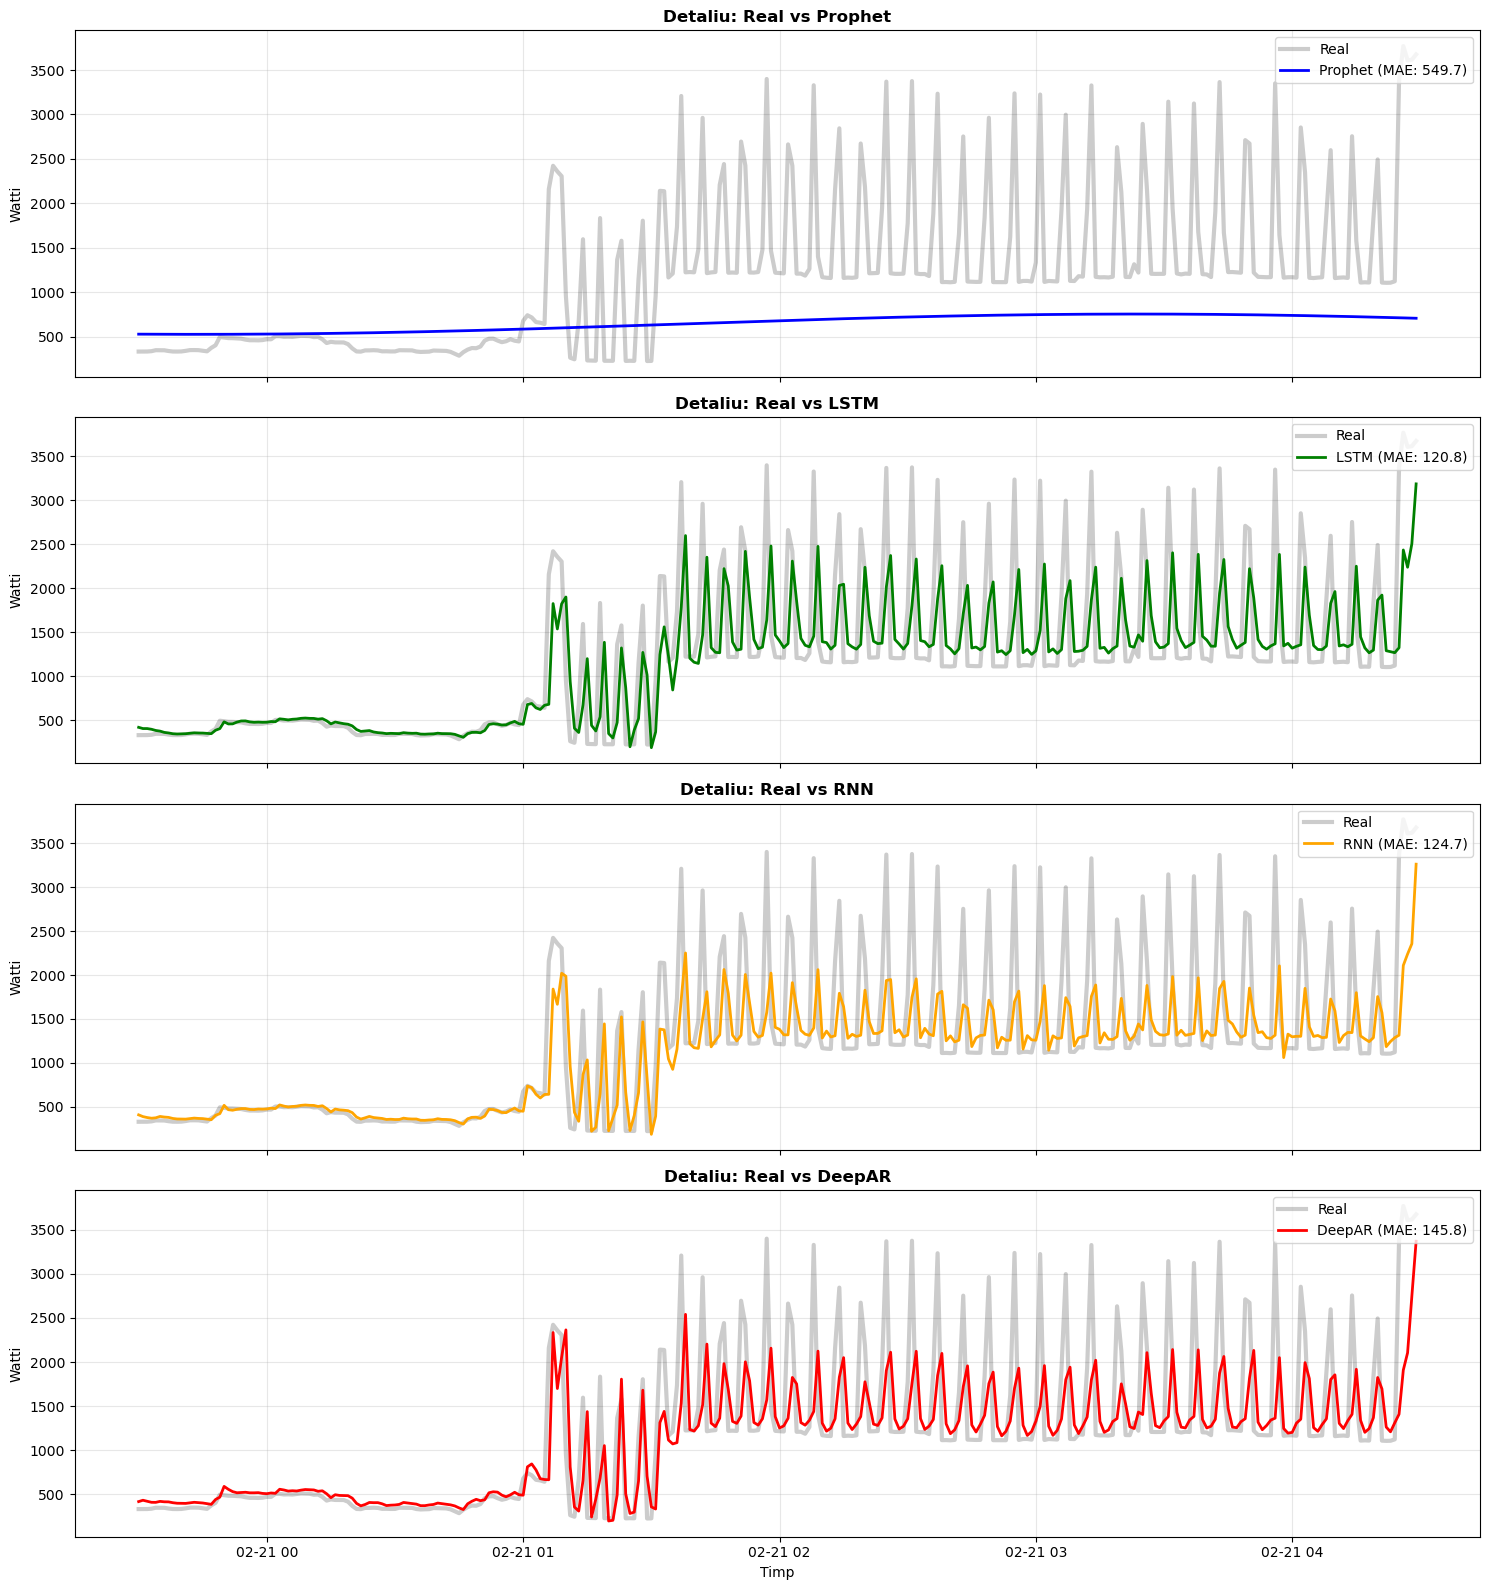

In [14]:
# --- CELULA 7: COMPARATIE FINALA ---

print("\n=== CLASAMENT COMPLET ===")
print(f"{'MODEL':<12} | {'RMSE':<10} | {'MAE':<10} | {'TIMP (sec)':<10}")
print("-" * 50)

metrici_rmse = {}
metrici_mae = {}

for model_name, pred in rezultate_finale.items():
    min_len = min(len(test_data), len(pred))
    y_true = test_data['Aggregate'].iloc[:min_len]
    y_pred = pred[:min_len]
    
    # Calcul metrici
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    metrici_rmse[model_name] = rmse
    metrici_mae[model_name] = mae

# Sortare si afisare
for nume, rmse in sorted(metrici_rmse.items(), key=lambda x: x[1]):
    mae = metrici_mae[nume]
    timp = timpi_antrenare.get(nume, 0)
    print(f"{nume:<12} | {rmse:.2f}     | {mae:.2f}     | {timp:.2f}s")

# GRAFIC
# Setari afisare
ZOOM = 300 
test_zoom = test_data.index[:ZOOM]
val_real = test_data['Aggregate'].values[:ZOOM]
colors = {'Prophet': 'blue', 'LSTM': 'green', 'RNN': 'orange', 'DeepAR': 'red'}

# Cream o figura cu atatea randuri cate modele avem
num_modele = len(rezultate_finale)
fig, axes = plt.subplots(nrows=num_modele, ncols=1, figsize=(15, 4 * num_modele), sharex=True)

# Daca avem un singur model, axes nu e lista, il facem lista
if num_modele == 1:
    axes = [axes]

for i, (nume, pred) in enumerate(rezultate_finale.items()):
    ax = axes[i]
    
    # 1. Plotam valorile reale (ca fundal)
    ax.plot(test_zoom, val_real, label='Real', color='black', alpha=0.2, linewidth=3)
    
    # 2. Plotam predictia modelului curent
    if nume in colors:
        culoare = colors[nume]
    else:
        culoare = 'purple'
        
    mae_curent = metrici_mae.get(nume, 0) # Luam MAE pentru legenda
    ax.plot(test_zoom, pred[:ZOOM], label=f'{nume} (MAE: {mae_curent:.1f})', color=culoare, linewidth=2)
    
    # Configurare axe si legenda
    ax.set_title(f'Detaliu: Real vs {nume}', fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_ylabel('Watti')

plt.xlabel('Timp')
plt.tight_layout()
plt.show()